
<img src='https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png' width=500px>

# JuptyterCon 2020 | Deep Learning Development with PyTorch

### Agenda:
* Developing a model with Jupyter on Colab - data handling, model development and training and visualizing loss curves using TensorBoard, model evaluation.
* Interpreting the model with Captum and understanding what is attributing to the predictions
* Benchmarking different hardware backends using CPUs, GPUs and Cloud TPUs 

### Let's start with importing all of the packages


In [36]:
# matplotlib is helpful for making little visuals and charts
import matplotlib.pyplot as plt
# numpy is a dependency for PyTorch but also really handy for manipulating data 
import numpy as np

# the standard PyTorch imports including torchvision for computer vision related artifacts
import torch
import torchvision
import torchvision.transforms as transforms

# some additional modules within PyTorch to help us define our network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### We can check on our GPU and what luck of the draw we got


In [37]:
# shell command gives you all you need to know about what GPU you have on your machine
!nvidia-smi

Mon Sep 21 03:34:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    897MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## PyTorch allows all kinds of tensor operations similar to numpy - Let's give it a try!


In [38]:
# construct a randomly initialized matrix
x = torch.rand(5, 3)
print(x)

tensor([[0.2648, 0.1151, 0.2899],
        [0.5168, 0.6404, 0.4530],
        [0.6793, 0.7065, 0.0409],
        [0.2947, 0.3388, 0.5016],
        [0.7138, 0.8649, 0.4612]])


In [39]:
# construct a matrix filled zeros and of dtype long
y = torch.ones(5, 3, dtype=torch.long)
print(x)

tensor([[0.2648, 0.1151, 0.2899],
        [0.5168, 0.6404, 0.4530],
        [0.6793, 0.7065, 0.0409],
        [0.2947, 0.3388, 0.5016],
        [0.7138, 0.8649, 0.4612]])


In [40]:
# let's add the tensors up
print(x+y)

tensor([[1.2648, 1.1151, 1.2899],
        [1.5168, 1.6404, 1.4530],
        [1.6793, 1.7065, 1.0409],
        [1.2947, 1.3388, 1.5016],
        [1.7138, 1.8649, 1.4612]])


In [41]:
# full support for numpy style indexing
print(x[:,1])

tensor([0.1151, 0.6404, 0.7065, 0.3388, 0.8649])


### We can also convert Torch tensors to numpy arrays

In [42]:
# a is a tensor. We can use any number of factory functions to create new tensors. We are using torch.ones here to create a tensor of all 1s.
a = torch.ones(5)
print(a)

tensor([1., 1., 1., 1., 1.])


In [43]:
# we can cast a as a numpy array using the .numpy() api
b = a.numpy()
print(b)

[1. 1. 1. 1. 1.]


### And easily run these tensors on Cuda devices

In [44]:
# using a bit of logic is handy to ensure you fall back gracefully to the cpu if a gpu isn't available
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

tensor([[1.2648, 1.1151, 1.2899],
        [1.5168, 1.6404, 1.4530],
        [1.6793, 1.7065, 1.0409],
        [1.2947, 1.3388, 1.5016],
        [1.7138, 1.8649, 1.4612]], device='cuda:0')
tensor([[1.2648, 1.1151, 1.2899],
        [1.5168, 1.6404, 1.4530],
        [1.6793, 1.7065, 1.0409],
        [1.2947, 1.3388, 1.5016],
        [1.7138, 1.8649, 1.4612]], dtype=torch.float64)


# Fashion MNIST - let's classify some clothing!

We'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the hand written digit MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes including shoes, shirts, etc. Below is a visualization of the data.

<img src='https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/03/Fashion-MNIST.png' width=500px>




### Load Our Dataset

In [45]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### We can visualize some training examples

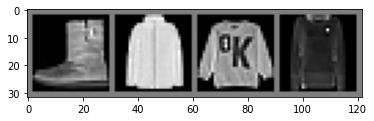

In [46]:
# functions to show images in the training set

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Define our network architecture

In this case, we are using fairly basic convolutional neural network 

In [47]:
import torch.nn as nn
import torch.nn.functional as F

# Creating a class for our model and subclassing nn.Module to take advantage of the layers available
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

### Defining our loss function and optimizer

In [48]:
import torch.optim as optim
model = Classifier()

# defining a metric for our loss function
criterion = nn.NLLLoss()

# selecting our optimizer, in this case the Adam optimizer. We also specify the hyperparameter our learning rate here.
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Setting up TensorBoard

In [49]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')
writer.close()
# this is allows TensorBoard to work in a Jupyter environment. Super handy!
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### We can also use torchvision to visualize our data and write it TensorBoard

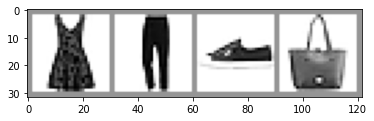

In [50]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

### Let's add a way to visualize our graph in TensorBoard


In [51]:
writer.add_graph(model, images)
writer.close()

### The Training Loop

In [ ]:
epochs = 10
writer = SummaryWriter()
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        # zeroing out our gradients 
        optimizer.zero_grad()
        # taking a backward pass
        loss.backward()
        # taking a step 
        optimizer.step()
        
        # calculating our loss
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/1000}")
        # logging our loss to TensorBoard
        writer.add_scalar('training loss',
                            running_loss / 1000)
        
writer.close()

Training loss: 8.417526966446808


### Let's get TensorBoard running

In [ ]:
tensorboard --logdir=runs


### Let's test the network on our test set data!

In [ ]:
# we've created a handy function that plots our inference results
def view_classify(img, ps, version="Fashion"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [ ]:
# let's do a prediction!
images, labels = next(iter(testloader))

img = images[2].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

## So what's next?

Head to [pytorch.org](https://pytorch.org/) for lots of tutorials, blogs and other educational materials. Plus all tutorials have Jupyter NBs and direct links to Colab!!